<a href="https://colab.research.google.com/github/RaghunandanVenkatesh/LearningToSee/blob/master/RL_Hvac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [12]:
#inputs for plant
T_oat = 30.0
PWM_front_box = 30.0
T_enginewater_set = 80.0
POS_fresh_air_flap = 40.0


In [24]:
np.exp(-5)

0.006737946999085467

# Engine water temp

50.0
37.33046720538268
30.36256230525501
25.623356011772906
22.285610367301956
19.79394825586334
17.903327171238814
16.425715175652847
15.262056826562514
14.328173883169299
13.576723767585506
12.963500294384048
12.463493804013183
12.05087522491587
11.71163781814819
11.429462874904146
11.19630033839644
11.001185644621756
10.839526825296161
10.703565394580636
10.590824976482338
10.495556470433911
10.416629680415866
10.349598003933536
10.294213299731325
10.246894391958321
10.207983721800957
10.174485598291255
10.14714419685167


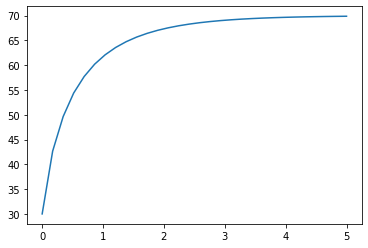

In [31]:
dt = np.linspace(0,5,30)
T_enginewater = []
for values in dt:
  if values == 0:
    T_enginewater.append(T_oat)
  else:
    print(T_enginewater_set - T_enginewater[-1])
    T_enginewater.append(T_oat + ( T_enginewater_set + T_oat - T_enginewater[-1]) * (1 - np.exp(-values))) 
plt.plot(dt, T_enginewater)

# Airoutlet temperature

In [9]:
water_val_pos_list = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
A_list = np.array([0, 0.6011, .61, 0.6, 1.88, 1.88, 2.1, 2.1, 2.1, 2.5, 3.5])
lookup = UnivariateSpline(water_val_pos_list, A_list, k=1, s=0.0)
print(lookup(20))
T_fap = T_oat

0.61


In [10]:
T_air_in = T_oat * POS_fresh_air_flap/100 + T_fap * (1 - POS_fresh_air_flap/100)
A = lookup(POS_fresh_air_flap)
eff = 1 - np.exp(-POS_fresh_air_flap*A/100)
T_airout = T_air_in + (T_enginewater - T_air_in) * eff

# room temperature 

In [5]:
# initialization
hA_screen = 0.0007
hA_shell = 0.0029
convfactor = 0.0016
mcp_shell = 0.83
dt = 1 # sample time
T_shell = T_oat



In [6]:
T_screen = T_oat
d_T_fap = hA_screen * (T_screen - T_fap) + hA_shell * (T_shell - T_fap)
d_T_fap += PWM_front_box * convfactor * 0.718 * (T_airout - T_fap)
T_fap = d_T_fap * dt + T_fap
T_shell = T_shell - hA_shell * (T_shell - T_fap)/mcp_shell